# What Strategy?
### Based on yelp challenge <a href='https://www.yelp.com.au/dataset/challenge'>dataset </a>

#### Author: Ignacio Recasens

### Abstract

To determine the business strategy that would improve chances of success the most, we performed three analyses that complemented each other. First performing **sentiment analysis** over customer reviews, second finding the most significant business attributes that positively correlate to a higher business rating or stars, and finally performing a qualitative analysis through a conjoint analysis over a survey sent to people residing mainly in Las Vegas.

The purpose of this notebook is to show the steps taken to determine the key **differentiators** for our Ramen Restaurant Chain using **Sentiment Analysis** over Yelp customer reviews. In particular we want to find the most frequently mentioned **terms** (e.g. "flavour", "Service", "Menu") that seems to have the strongest correlation with a succesful restaurant (based on business rating). 

To achieve this the folliwing procedure was taken: 


**I. Pre-processing**

1. **Tokenization:** Including removal of stopwords (for the purpose of extracting main terms they were not required) and treating case-folding and non-alphanumeric characters.
2. **Synonyms:** Terms were grouped together as a means of dimensionality reduction for most common synonyms (ex. “service”, “staff”, “waitress” are all transformed into “service”).
3. **Negation:** Sentiment score for negated opinion words are reversed. Appending the suffix “_NEG” to every word between a negation and a punctuation mark (Das and Chen 2001 ).
4. **Part-of-Speech tagging:** Critical for three reasons. (1) To find adjectives which are considered as opinion words, (2) to extract it’s sentiment score since words have different polarity depending on their POS tag and (3) to extract main terms where Nouns (NN) and Noun-phrases (NNP) were considered as potential candidates. 


**II. Main terms extraction**

The methodology used to extract main terms that customers were discussing considered a previous manual step. By extracting all the terms and their frequencies over all the corpus, we manually marked those terms that were relevant, in particular taking a special emphasis on those that were tagged as NN or NNP and that had a higher frequency. This data was then used to filter all the reviews to make sure that only those that had at least one of this terms were considered, and also to identify in the reviews the main terms that would be assigned a sentiment score.


**III. Main terms sentiment score**
To assign a sentiment score for each term in a review we considered the following: 
1. List of words that would fix sentiment scores from wordnet. For example to change some words polarity from positive to negative or viceversa, and to ignore other words (for example “normal”, “yellow”).
2. List of words that failed to be tagged as adjectives but that should serve as opinion words as well (for example “love” or “cool”). 
3. Invert polarity of words when they were negated. 
4. The “Minqing Hu and Bing Liu” lexicon as an alternative of wordnet in case a score was missing.
5. A maximum of 3 opinion words assigned to each term and in a maximum distance of 5 tokens (more than that could mean that they would get assigned opinion words that were supposed to be assigned to a different term).
6. Compute the sentiment score  weighting their distance (the further apart the lesser its weight). This was proposed by Ding et al as follows:
<img src="formula_distance.PNG">

        i and k are opinion words, t is the main term , SO(i) is the score for the opinion word i and d(i,t) and d(k,t) is the absolute distance between the opinion word and the main term.
        
           Example: 
   <img src="Example1.PNG">
   <img src="Example2.PNG">



This analysis was repeated several times using different clusters of data (e.g. only Open Restaurants, Restaurants from Las Vegas, etc.).


### Outline

#### 1. <a href='#rating'>Business Rating Distribution</a>

#### 2. <a href='#nlp_functions'>Load Functions</a>

#### 3. <a href='#nlp'>Customer Reviews Main Terms Analysis</a>
31. <a href='#mysql'>Load Data : MySQL Queries</a>
32. <a href='#nlp_terms'>Get Main Terms</a>

#### 4. <a href='#nlp_sentiment_terms'>Sentiment for Main Terms in the Ramen Industry</a>
41. <a href='#open_ramen_market'>Open Ramen Restaurants in all Market</a>
42. <a href='#open_ramen_states'>Open Ramen Restaurants by State</a>
43. <a href='#closed_ramen_market'>Closed (failed) Ramen Restaurants all Market</a>
44. <a href='#closed_ramen_states'>Closed (failed) Ramen Restaurants by State</a>
45. <a href='#top'>Top Open Ramen Restaurants</a>
46. <a href='#top_states'>Top Open Ramen Restaurants by State</a>
47. <a href='#low'>Worst Open Ramen Restaurants</a>
48. <a href='#low_states'>Worst Open Ramen Restaurants by State</a>
49. <a href='#top_vs_low'>Top vs Worst Open Ramen Restaurants Analysis</a>

#### 5. <a href='#nlp_sentiment_terms2'>Sentiment for Main Terms in Las Vegas (all relevant Cuisines)</a>
51. <a href='#mysql2'>Load Data : MySQL Queries</a>
52. <a href='#open_vegas_market'>Open Vegas Restaurants</a>


<a id='load'></a>
## Load libraries

In [ ]:
# MySQL
import MySQLdb # For Windows: 'conda.exe install mysql-python' or 'pip install mysqlclient'

# DATA MUNGING
import numpy as np
import math
import pandas as pd
import random
import timeit
from collections import defaultdict
import populartimes

# NLP
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import sentiment
from autocorrect import spell # For spelling correction
from urllib import request


# DATA VIZUALIZATION
import seaborn as sns # For Data VIzualization
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.core.display import HTML
from bokeh.models import HoverTool
from wordcloud import WordCloud


c:\users\milo\anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


<a id='rating'></a>
## 1 Business Rating Distribution

To get an overview of the distribution of restaurants ratings:

In [50]:
connection = MySQLdb.connect("localhost",'root', 'irecasens_2017', 'yelp_db')
cursor = connection.cursor()

sql = "select * from tbl_V_Ramen_Businesses" # Extracts only Ramen Restaurants in all market

cursor.execute(sql)
df = cursor.fetchall()

connection.close()

df = pd.DataFrame(list(df))
df.columns = ['business_id','name',  'neighbourhood', 'address', 'city', 'state', 'PO', 'lat', 'lng', 'business_stars', 'reviews', 'is_open']

display(df.head())


,business_id,name,neighbourhood,address,city,state,PO,lat,lng,business_stars,reviews,is_open
0,YFEwCxc-9WRRVGgRv_-p7Q,Mcramyun,Downtown Core,1 Baldwin Street,Toronto,ON,M5T 1L1,43.6562,-79.3923,3.0,25,0
1,9BQGpsIRhs9cRHuGh9xuJw,Toko Japanese Steak House,,1855 State Route 59,Kent,OH,44240,41.1555,-81.3270,4.0,36,1
2,fJ-2acaqvWOsujUTAJB-ew,Raijin Ramen,Downtown Core,24 Wellesley Street W,Toronto,ON,M4Y 2X6,43.6648,-79.3859,3.5,287,1
3,pJVPEicWbvcz8ATQGick6g,Yuki Ramen,Ville-Marie,1616 Rue Sainte-Catherine O,Montréal,QC,H3H 1L7,45.4940,-73.5788,4.0,23,1
4,3sIEwr4LPEruEt2q8ImypQ,Noodle Uchi,Oakland,415 S Craig St,Pittsburgh,PA,15213,40.4446,-79.9486,2.5,13,1


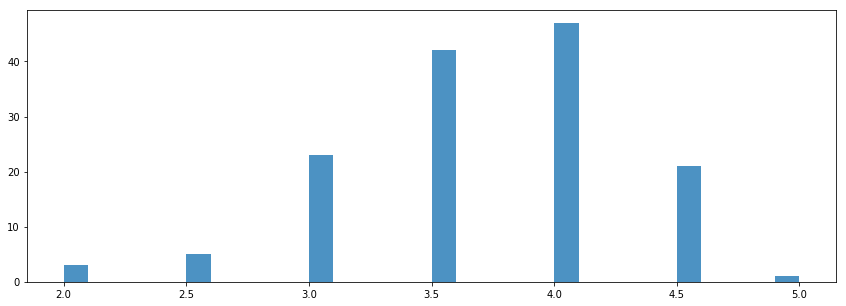

,0.0,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0
business_stars,2.0,2.0,2.53,3.0,3.0,3.5,3.5,3.5,4.0,4.0,4.0,4.5,4.5,4.5,5.0


In [51]:
plt.figure(figsize=(14.5,5))
plt.hist(df['business_stars'], bins=30, alpha=0.8)
plt.show()

pd.DataFrame(round(df["business_stars"].quantile([0, 0.01, 0.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]),2)).T  

<a id='nlp_functions'></a>
## 2 Load Functions


In [2]:
def create_wordcloud(frequencies, terms):
    words = pd.Series(data = list(frequencies), index = list(terms) )
    wordcloud = WordCloud(max_font_size=50)
    wordcloud.generate_from_frequencies(words)
    plt.imshow(wordcloud)
    

In [3]:
colors = ["black", "red", "blue", "white", "gray", "green","yellow", "pink", "gold"]
set_as_neutral = ["elderly", "several", "extra", "upgraded", "enough", "picky"] + colors
set_as_positive = ["flavorful", "surprised", "several", "cheap", "fresh", 
                   "sincere", "tasty", "plentiful", "unusual"] # wordnet have it as negative, should be positive
set_as_negative = ["old", "low", "instant", "expensive", "overpriced", "overrated"] # wordnet have it as positive, should be negative. 

word_exceptions = ["missing", "broken", "love", "awesome", "cool", 
                   "attentive", "satisfying", "instant",
                  "plentiful", "tasty", "sincere"] # They are not tagged as JJ sometimes, they should.

### Load Alternative to WordNet
url_pos = r'https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt'
url_neg = r'https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt'

pos_list = request.urlopen(url_pos).read().decode('utf-8')[1:]
pos_list = pos_list[pos_list.find("a+"):].split("\n")

neg_list = request.urlopen(url_neg).read().decode('ISO-8859-1')[1:]
neg_list = neg_list[neg_list.find("2-faced"):].split("\n")


def get_synonym(word):
    synonyms = [
        ["spot", "location", "neighborhood"],
        ["service", "staff", "server", "waitress", "servers", "waiter", "waiters", "waitresses", "hostess", "employees"],
        ["price", "pricing", 'prices', "money", "cost"],
        ["bar", "cocktails", "drinks", "drink", "beer", "beers"],
        ["portion", "portions", "slices", "quantity", "size"],
        ["line", "lines"],
        ["decor", "style", "feel",  "ambiance","ambience" ,"environment", "vibe", "concept", "mood", "design", "atmosphere", "scene"],
        ["variety", "options", "selection", "choices", "courses", "offerings"],
        ["reservation", "reservations"],
        ["appetizer", "appetizers"],
        ["bowl", "bowls"],
        ["broth", "broths", "soup", "soups"],
        ["chashu", "chasu"],
        ["dish", "dishes"],
        ["dessert", "desserts"],
        ["egg", "eggs"],
        ["flavour", "flavor", "flavors", "flavours", "taste", "food", "meal", "course", "tastes"],
        ["mushroom", "mushrooms"],
        ["noodles", "noodle"],
        ["owner", "owners"],
        ["peppers", "pepper"],
        ["ramen", "ramens"],
        ["sauces", "sauce"],
        ["seats", "seat", "seating"],
        ["table", "tables"],
        ["restaurant", "place", "places"]
    ]
    synonyms_parent = ["location", "service", "price", "bar", "portion", 
                       "line","ambiance","offerings", "reservation", 
                       "appetizer", "bowl", "broth", "chashu", "dish", "dessert", "egg", "flavour",
                      "mushrooms", "noodles", "owner", "pepper","ramen", "sauce", "seats", "tables", "restaurant"]
    
    for i in range(len(synonyms)):
        if word in synonyms[i]:
            return synonyms_parent[i]
    
    return word

def correction(x):
    ok_words = ["microsd"]
    
    if x.find("_NEG") == -1 and x not in ok_words: # Don't correct if they are negated words or exceptions
        return spell(x)
    else:
        return x

    
def get_tokens(df, stem = False, negation = False, correction = False):
    stemmer = PorterStemmer()
    stop = set(stopwords.words('english'))
    reviews = []    
    i = 1
    
    for review in df["review"]:
        tokenized_review = []      

        review = str(review).lower() # lowercase
        
        # Remove every character except A-Z, a-z,space 
        # and punctuation (we'll need it for negation)
        review = re.sub(r'[^A-Za-z /./!/:/?]','',review) 
        
        # mark_negation needs punctuation separated by white space.
        review = review.replace(".", " . ")   
        review = review.replace("!", " ! ")
        review = review.replace(":", " : ")
        review = review.replace("?", " ? ")
        
        tokens = word_tokenize(review)
        
        
        for token in tokens:
            # Remove single characters and stop words
            if (len(token)>1 or token == ".") and token not in stop: 
                if stem:
                    tokenized_review.append(stemmer.stem(get_synonym(token)))            
                else:
                    tokenized_review.append(get_synonym(token))
        
        if negation:
            tokenized_review = sentiment.util.mark_negation(tokenized_review)   
        
        # Now we can get rid of punctuation and also let's fix some spellings:
        if correction:
            tokenized_review = [correction(x) for x in tokenized_review if x != "." ]
        
            
        reviews.append(tokenized_review)
        
        if i%1000 == 0:
            print('Tokenization progress: ', (i/len(df["review"]))*100, "%")
        i = i + 1
        
    return reviews
 

def get_pos(tokenized_reviews):
    tokenized_pos = []
    i = 1
    
    for review in tokenized_reviews:
        tokenized_pos.append(nltk.pos_tag(review))
        
        if i%1000 == 0:
            print('POS progress: ', (i/len(tokenized_reviews))*100, "%")
        i = i + 1
    
    return tokenized_pos
        
    
def get_frequency(tokens):    
    term_freqs = defaultdict(int)    
    
    for token in tokens:
        term_freqs[token] += 1 
            
    return term_freqs


def get_tdm(tokenized_reviews):
    tdm = []
    
    for tokens in tokenized_reviews:
        tdm.append(get_frequency(tokens))
    
    return tdm

def normalize_tdm(tdm):    
    tdm_normalized = []
        
    for review in tdm:
        den = 0
        review_normalized = defaultdict(int)
        
        for k,v in review.items():
            den += v**2
        den = math.sqrt(den)
    
        for k,v in review.items():
            review_normalized[k] = v/den
        
        tdm_normalized.append(review_normalized)
        
    return tdm_normalized

def get_all_terms(tokenized_reviews):
    all_terms = []
    
    for tokens in tokenized_reviews:
        for token in tokens:
            all_terms.append(token)
            
    return(set(all_terms))
    
def get_all_terms_dft(tokenized_reviews, all_terms):
    terms_dft = defaultdict(int)  
    
    for term in all_terms: 
        for review in tokenized_reviews:
            if term in review:
                terms_dft[term] += 1
                
    return terms_dft


def get_tf_idf_transform(tokenized_reviews, tdm, n_reviews):
    tf_idf = []        
    all_terms = get_all_terms(tokenized_reviews)    
    terms_dft = get_all_terms_dft(tokenized_reviews, all_terms)
    
    for review in tdm:
        review_tf_idf = defaultdict(int)
        for k,v in review.items():
            review_tf_idf[k] = v * math.log(n_reviews / terms_dft[k], 2)
        
        tf_idf.append(review_tf_idf)     
    
    return tf_idf


def get_idf_transform(tokenized_reviews, tdm, n_reviews):
    idf = []    
    terms_dft = defaultdict(int)    
    
    all_terms = get_all_terms(tokenized_reviews)
    
    for term in all_terms: 
        for review in tokenized_reviews:
            if term in review:
                terms_dft[term] += 1
    
    for review in tdm:
        review_idf = defaultdict(int)
        for k,v in review.items():
            review_idf[k] = math.log(n_reviews / terms_dft[k], 2)
        
        idf.append(review_idf)     
    
    return idf


def get_freq_pos(tokenized_pos):
    tokenized_pos_all = defaultdict(int) 
    
    for review in tokenized_pos:
        for term in review:
                tokenized_pos_all[term] += 1     
    
    tokenized_df = pd.DataFrame()
    data = pd.DataFrame({"ID": range(len(tokenized_pos_all))})
    tokenized_df.append(data)
    
    lst_term = []
    lst_pos = []
    lst_val = []
    
    for k,v in tokenized_pos_all.items():
        try:
            lst_term.append(k[0])
            lst_pos.append(k[1])
            lst_val.append(v)
        except: 
            print("didn't work for k: ", k)
        
    tokenized_df["term"] = lst_term
    tokenized_df["pos"] = lst_pos
    tokenized_df["mentions"] = lst_val
    
    
    return tokenized_pos_all, tokenized_df

def filter_with_marked_terms(tokenized_reviews, df, marked_terms):    
    to_keep_in = []  
    
    i = 0    
    for review in tokenized_reviews:
        for token in review:
            if token in marked_terms:
                to_keep_in.append(i)
                break
        
        i +=1
        
    return to_keep_in
            
    
    
def compute_score(word, word_neg):
    '''
    Received two words; the original and it's negated version in case it was negated.
    Returns a score as an int with 1 for positive, -1 for negative and 0 for neutral.
    '''
    
    if word in set_as_neutral: 
        return 0
    
    if word in set_as_positive:
        if word_neg.find("_NEG") == -1: # Make sure it was not negated, if it wasn't set as positive.
            return 1
        else:
            return -1
        
    if word in set_as_negative:
        if word_neg.find("_NEG") == -1: # Make sure it was not negated, if it wasn't set as negative.
            return -1
        else:
            return 1
        
    word2 = ''.join([word,".a.01"])
    try:
        pos_score = swn.senti_synset(word2).pos_score()
        neg_score = swn.senti_synset(word2).neg_score()
    except:
        if word in pos_list:
            pos_score = 1
            neg_score = 0
        elif word in neg_list:
            pos_score = 0
            neg_score = 1
        else:
            return 0 # No match, return word as neutral.
    
    if pos_score > neg_score:
        if word_neg.find("_NEG") == -1: # Make sure it was not negated, if it wasn't return as positive.
            return 1
        else:
            
            return -1
    elif neg_score > pos_score:
        if word_neg.find("_NEG") == -1:   # Make sure it was not negated, if it wasn't return as negative.          
            return -1
        else:
            
            return 1   
    else:
        if word in pos_list:
            return 1
        elif word in neg_list:
            return -1
        else:
            return 0
        
        
def extract_marked_terms_opinion_words(review, review_neg, max_opinion_words = 3, max_distance = 5, use_distance = False):
    '''
    Receives two lists for a specific review, one in its original form and another in its negated form.
    max_opinion_words is the maximum number of adjectives to look for each term.
    max_distance for the lenght of tokens to go look for.
    Returns a dictionary with the sentiment of each adjective assigned for each term in a review.    
    '''
        
    review_marked_terms_sentiment = defaultdict(list) 
    i = 0
    
    temp_review = []
    for word in review: 
        word = word + ("free",)
        temp_review.append(list(word))
            
    for i in range(len(review)):
        if review[i][0] in marked_terms:            
            keep_forward = True
            keep_backward = True
            opinion_words = 0
            
            for j in range(1,max_distance+1):
                
                if  i+j >= len(review):
                    keep_forward = False
                if keep_forward:
                    if  review[i+j][0] in marked_terms or opinion_words >= max_opinion_words or review[i+j][0] == ".":
                        keep_forward = False

                    elif i+j < len(review) and (review[i+j][1] in ["JJ", "JJR", "JJS"] or review[i+j][0] in word_exceptions) and temp_review[i+j][2] == "free":
                        sentiment = defaultdict(int)
                        score = compute_score(review[i+j][0], review_neg[i+j][0])                   
                        if score == 0: continue

                        if use_distance:
                            distance = j
                        else:
                            distance = 1

                        sentiment[review[i+j][0]] = (score,distance)
                        review_marked_terms_sentiment[review[i][0]].append(sentiment)
                        temp_review[i+j][2] = "used"
                        opinion_words +=1
                
                
                if  i-j < 0:
                    keep_backward = False
                if keep_backward:
                    if  review[i-j][0] in marked_terms or opinion_words >= max_opinion_words or review[i-j][0] == ".":
                        keep_backward = False

                    elif i-j > -1 and (review[i-j][1] in ["JJ", "JJR", "JJS"] or review[i-j][0] in word_exceptions) and temp_review[i-j][2] == "free":
                        sentiment = defaultdict(int)
                        score = compute_score(review[i-j][0], review_neg[i-j][0])         

                        if score == 0: continue

                        if use_distance:
                            distance = j
                        else:
                            distance = 1

                        sentiment[review[i-j][0]] = (score,distance)

                        review_marked_terms_sentiment[review[i][0]].append(sentiment)
                        temp_review[i-j][2] = "used"  
                        opinion_words +=1
                
                if not keep_forward and not keep_backward:
                    break
    
    return review_marked_terms_sentiment


def consolidate_score(marked_terms_dict):
    '''
    Receives the dictionary of a marked term defined by the sentiments of its adjectives.
    Returns the total score using the formula described below (basically weighted averages according to distance)
    '''    
    num = 0
    den = 0        
    
    for opinion in marked_terms_dict:  
        for k, v in opinion.items():
            num += v[0]*(1/v[1]) # v[0] is the score, v[1] is the distance
            den += 1/v[1]        # additional term (not in the formula) to make sure weights sum up to 1     

    return num/den



def compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True):
    
    if len(tokenized_pos) != len(tokenized_pos_neg):
        print("FATAL ERROR: Different lenght between tokenized_pos and tokenized_pos_neg")
        return None
    
    else:
        
        reviews_sentiment_scores = []        
        
        for i in range(len(tokenized_pos)):
            review_sentiment_score = defaultdict(int)
            
            review_marked_terms_opinion_words = extract_marked_terms_opinion_words(tokenized_pos[i], tokenized_pos_neg[i], max_distance = max_distance, use_distance = use_distance)
            
            for k, v in review_marked_terms_opinion_words.items():
                review_sentiment_score[k] = consolidate_score(v)
                
            reviews_sentiment_scores.append(review_sentiment_score)
            
        return reviews_sentiment_scores

    
def get_NN_count(tokenized_pos):
    '''
    Received a tokenized review with their POS, and returns the number of nouns or marked terms it has.
    '''
    
    NN_count = []
    
    for review in tokenized_pos:
        review_NN_count = 0
        for token in review: 
            if token[1] in ["NN", "NNS", "NNP"] or token[0] in marked_terms:
                review_NN_count += 1
        NN_count.append(review_NN_count)
    
    return NN_count




In [4]:
# Example
compute_score("awful", "awful_NEG")

1

<a id='nlp'></a>
# 3. Customer Reviews Main Terms Analysis
<a id='mysql'></a>
## 3.1 Load Data : MySQL Queries

Let's load the review data.

In [52]:
connection = MySQLdb.connect("localhost",'root', 'irecasens_2017', 'yelp_db')
cursor = connection.cursor()

sql = "select * from tbl_V_reviews_business" # Extracts only Ramen Restaurants in all market

cursor.execute(sql)
df = cursor.fetchall()

connection.close()

df = pd.DataFrame(list(df))
df.columns = ['business_id','user_id', 'category', 'date', 'review','stars', 'useful', 'funny', 'cool', 'name', 'city', 'state', 'latitude', 'longitude', 'business_stars', 'review_count', 'is_open']
display("Total Reviews: "+ str(len(df)))

df = df.loc[df["useful"] >=1]

df_top = df.loc[df["business_stars"] >4]
df_low = df.loc[df["business_stars"] <=3]

df_closed = df.loc[df["is_open"] == 0]
df = df.loc[df["is_open"] == 1]

display("Total Reviews (useful): "+ str(len(df)))
display("Top restaurants reviews: "+ str(len(df_top)))
display("Low restaurants reviews: "+ str(len(df_low)))
display("Open restaurants reviews: "+ str(len(df)))
display("Closed restaurants reviews: "+ str(len(df_closed)))

display(df.head())


'Total Reviews: 21401'

'Total Reviews (useful): 7457'

'Top restaurants reviews: 1021'

'Low restaurants reviews: 870'

'Open restaurants reviews: 7457'

'Closed restaurants reviews: 925'

,business_id,user_id,category,date,review,stars,useful,funny,cool,name,city,state,latitude,longitude,business_stars,review_count,is_open
23,9BQGpsIRhs9cRHuGh9xuJw,aHOddpmocRnDpdzxkgtvrA,Ramen,2017-05-14,"T\nDespite the humble exterior, this place is ...",5,1,1,1,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1
25,9BQGpsIRhs9cRHuGh9xuJw,NS-H7FCs8w09lUGSceNLQA,Ramen,2015-05-07,I was so excited to come and check out this ne...,1,2,0,2,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1
28,9BQGpsIRhs9cRHuGh9xuJw,KgQnRvsPSrJJTOCp-reYZA,Ramen,2017-03-07,Preferred lunch vs dinner here...much better v...,3,2,2,1,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1
34,9BQGpsIRhs9cRHuGh9xuJw,LSnRglzo3ScMmH_JvdX_eA,Ramen,2015-07-13,Wasnt the best sushi i have ever had but servi...,3,1,0,0,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1
41,9BQGpsIRhs9cRHuGh9xuJw,oNnOl4J0bYQ4TmdwC96vew,Ramen,2015-08-25,Absolutely fantastic! To be honest I was very ...,5,1,0,0,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1


<a id='nlp_terms'></a>
## 3.2 Get Main Terms

Get all the categories or terms that define a restaurant, and then manually mark those that are most frequent and relevant (usually those that are Nouns). 


In [6]:
tic = timeit.default_timer()

tokenized_reviews = get_tokens(df, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)
tokenized_pos_all, tokenized_df = get_freq_pos(tokenized_pos)

toc = timeit.default_timer()
print("minutes: ", (toc - tic)/60)

tokenized_df.to_csv('to_mark_terms.csv')
tokenized_df[0:3]


Tokenization progress:  13.41021858656296 %
Tokenization progress:  26.82043717312592 %
Tokenization progress:  40.23065575968888 %
Tokenization progress:  53.64087434625184 %
Tokenization progress:  67.05109293281481 %
Tokenization progress:  80.46131151937776 %
Tokenization progress:  93.87153010594072 %
POS progress:  13.41021858656296 %
POS progress:  26.82043717312592 %
POS progress:  40.23065575968888 %
POS progress:  53.64087434625184 %
POS progress:  67.05109293281481 %
POS progress:  80.46131151937776 %
POS progress:  93.87153010594072 %
minutes:  1.099340442634721


,term,pos,mentions
0,tdespite,RB,1
1,humble,JJ,12
2,exterior,JJ,22


After terms have been marked, load them into "Marked Terms"

In [7]:
marked = pd.read_excel('C:/Users/Ignacio/Yelp_Project/marked_terms.xlsx')
marked_terms = list(marked.loc[marked['is_marked'] == "x"]["term"])
marked_terms[0:3]


['ramen', 'place', 'food']

<a id='nlp_sentiment_terms'></a>
## 4 Sentiment for Main Terms

<a id='open_ramen_market'></a>
### 4.1 Open Ramen Restaurants in all Market

In [8]:

# Filter reviews that contain at least one marked term.
tokenized_reviews = get_tokens(df, stem = False, negation = False, correction = False)
to_keep_in = filter_with_marked_terms(tokenized_reviews, df, marked_terms)

print("Percentage of total reviews that have at least one marked term: " + str(len(to_keep_in) /len(df)))

df_filtered = df[df.index.isin(to_keep_in)]
df_filtered


Tokenization progress:  13.41021858656296 %
Tokenization progress:  26.82043717312592 %
Tokenization progress:  40.23065575968888 %
Tokenization progress:  53.64087434625184 %
Tokenization progress:  67.05109293281481 %
Tokenization progress:  80.46131151937776 %
Tokenization progress:  93.87153010594072 %
Percentage of total reviews that have at least one marked term: 0.9973179562826874


,business_id,user_id,category,date,review,stars,useful,funny,cool,name,city,state,latitude,longitude,business_stars,review_count,is_open
23,9BQGpsIRhs9cRHuGh9xuJw,aHOddpmocRnDpdzxkgtvrA,Ramen,2017-05-14,"T\nDespite the humble exterior, this place is ...",5,1,1,1,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
25,9BQGpsIRhs9cRHuGh9xuJw,NS-H7FCs8w09lUGSceNLQA,Ramen,2015-05-07,I was so excited to come and check out this ne...,1,2,0,2,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
28,9BQGpsIRhs9cRHuGh9xuJw,KgQnRvsPSrJJTOCp-reYZA,Ramen,2017-03-07,Preferred lunch vs dinner here...much better v...,3,2,2,1,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
34,9BQGpsIRhs9cRHuGh9xuJw,LSnRglzo3ScMmH_JvdX_eA,Ramen,2015-07-13,Wasnt the best sushi i have ever had but servi...,3,1,0,0,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
41,9BQGpsIRhs9cRHuGh9xuJw,oNnOl4J0bYQ4TmdwC96vew,Ramen,2015-08-25,Absolutely fantastic! To be honest I was very ...,5,1,0,0,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
43,9BQGpsIRhs9cRHuGh9xuJw,_MjgqPR1pvDnZZ6wCwabBQ,Ramen,2016-04-20,I have been to this place 5 times now. I do n...,5,6,1,3,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
44,9BQGpsIRhs9cRHuGh9xuJw,cQtEpt1F61IiNP3gRu7LIg,Ramen,2016-02-28,Went here last night for the all you can eat s...,2,1,0,0,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
48,9BQGpsIRhs9cRHuGh9xuJw,51munej7rdZuB7KfPofhaA,Ramen,2015-06-06,"If you have visited the Streetsboro location, ...",4,2,0,0,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
51,9BQGpsIRhs9cRHuGh9xuJw,9hDFwspnyvfvhpzL7D5kqw,Ramen,2017-02-25,Toko is my go-to sushi place for eating in or ...,4,3,0,3,Toko Japanese Steak House,Kent,OH,41.1555,-81.3270,4.0,36,1
53,fJ-2acaqvWOsujUTAJB-ew,Iu55D7RAAW8TACA3lN0w8Q,Ramen,2015-03-18,I am getting worse at reviewing ramen places b...,3,2,1,2,Raijin Ramen,Toronto,ON,43.6648,-79.3859,3.5,287,1


Now that we have the relevant reviews, let's start the main proces of Sentiment Analysis!

In [9]:
## TOKENIZE REVIEWS AND EXRACT THEIR POS

# Without negated words
tokenized_reviews = get_tokens(df_filtered, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)

# With negated words
tokenized_reviews_neg = get_tokens(df_filtered, stem = False, negation = True, correction = False)
tokenized_pos_neg = get_pos(tokenized_reviews_neg)


Tokenization progress:  41.70141784820684 %
Tokenization progress:  83.40283569641367 %
POS progress:  41.70141784820684 %
POS progress:  83.40283569641367 %
Tokenization progress:  41.70141784820684 %
Tokenization progress:  83.40283569641367 %
POS progress:  41.70141784820684 %
POS progress:  83.40283569641367 %


In [10]:
# EXAMPLE

# Sample review
lookup_product_id = 14

for val in df_filtered[df_filtered.index == lookup_product_id]["review"]: print(val) # Prints review

display(tokenized_pos[lookup_product_id]) # POS Tags without negated words
display(tokenized_pos_neg[lookup_product_id]) # POS Tags with negated words

# Extract sentiment for each marked term and store in a dictionary
review_marked_terms_opinion_words = extract_marked_terms_opinion_words(tokenized_pos[lookup_product_id], tokenized_pos_neg[lookup_product_id], max_distance = 5, use_distance = True)               
display(review_marked_terms_opinion_words)

display(review_marked_terms_opinion_words)

for k, v in review_marked_terms_opinion_words.items():
    print(k, " with final score: ", consolidate_score(v))
    


[('updating', 'VBG'),
 ('review', 'NN'),
 ('.', '.'),
 ('went', 'VBD'),
 ('lunch', 'NN'),
 ('pressed', 'VBN'),
 ('time', 'NN'),
 ('asked', 'VBN'),
 ('service', 'NN'),
 ('pack', 'NN'),
 ('flavour', 'NN'),
 ('go', 'VBP'),
 ('literally', 'RB'),
 ('eaten', 'RB'),
 ('.', '.'),
 ('waited', 'VBD'),
 ('nothing', 'NN'),
 ('.', '.'),
 ('went', 'VBD'),
 ('front', 'JJ'),
 ('counter', 'NN'),
 ('told', 'VBD'),
 ('threw', 'RP'),
 ('away', 'RB'),
 ('.', '.'),
 ('.', '.'),
 ('.', '.'),
 ('.', '.'),
 ('service', 'NN'),
 ('apparently', 'RB'),
 ('didnt', 'JJ'),
 ('understand', 'VBP'),
 ('english', 'JJ'),
 ('thought', 'NN'),
 ('finished', 'VBD'),
 ('flavour', 'NN'),
 ('.', '.'),
 ('super', 'JJ'),
 ('annoying', 'NN'),
 ('.', '.'),
 ('throws', 'VBZ'),
 ('whole', 'JJ'),
 ('flavour', 'JJ'),
 ('didnt', 'NN'),
 ('understand', 'VBP'),
 ('get', 'VB'),
 ('service', 'NN'),
 ('speak', 'NN'),
 ('english', 'NN'),
 ('also', 'RB'),
 ('.', '.'),
 ('.', '.'),
 ('.', '.'),
 ('employing', 'VBG'),
 ('someone', 'NN'),
 ('inter

[('updating', 'VBG'),
 ('review', 'NN'),
 ('.', '.'),
 ('went', 'VBD'),
 ('lunch', 'NN'),
 ('pressed', 'VBN'),
 ('time', 'NN'),
 ('asked', 'VBN'),
 ('service', 'NN'),
 ('pack', 'NN'),
 ('flavour', 'NN'),
 ('go', 'VBP'),
 ('literally', 'RB'),
 ('eaten', 'RB'),
 ('.', '.'),
 ('waited', 'VBD'),
 ('nothing', 'NN'),
 ('.', '.'),
 ('went', 'VBD'),
 ('front', 'JJ'),
 ('counter', 'NN'),
 ('told', 'VBD'),
 ('threw', 'RP'),
 ('away', 'RB'),
 ('.', '.'),
 ('.', '.'),
 ('.', '.'),
 ('.', '.'),
 ('service', 'NN'),
 ('apparently', 'RB'),
 ('didnt', 'VBZ'),
 ('understand_NEG', 'JJ'),
 ('english_NEG', 'NN'),
 ('thought_NEG', 'NN'),
 ('finished_NEG', 'NN'),
 ('flavour_NEG', 'NN'),
 ('.', '.'),
 ('super', 'JJ'),
 ('annoying', 'NN'),
 ('.', '.'),
 ('throws', 'VBZ'),
 ('whole', 'JJ'),
 ('flavour', 'NN'),
 ('didnt', 'NN'),
 ('understand_NEG', 'JJ'),
 ('get_NEG', 'NN'),
 ('service_NEG', 'NN'),
 ('speak_NEG', 'NN'),
 ('english_NEG', 'NN'),
 ('also_NEG', 'NN'),
 ('.', '.'),
 ('.', '.'),
 ('.', '.'),
 ('employ

defaultdict(list,
            {'flavour': [defaultdict(int, {'whole': (1, 1)})],
             'ramen': [defaultdict(int, {'tried': (1, 3)})]})

defaultdict(list,
            {'flavour': [defaultdict(int, {'whole': (1, 1)})],
             'ramen': [defaultdict(int, {'tried': (1, 3)})]})

flavour  with final score:  1.0
ramen  with final score:  1.0


In [11]:
# EXTRACT SENTIMENTS

NN_count = get_NN_count(tokenized_pos)

review_sentiment_scores = compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True)
review_sentiment_scores[:6]

df_filtered["Sentiments"] = list(review_sentiment_scores)
df_filtered["NN_count"] = list(NN_count)
df_filtered[:3]

c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,business_id,user_id,category,date,review,stars,useful,funny,cool,name,city,state,latitude,longitude,business_stars,review_count,is_open,Sentiments,NN_count
23,9BQGpsIRhs9cRHuGh9xuJw,aHOddpmocRnDpdzxkgtvrA,Ramen,2017-05-14,"T\nDespite the humble exterior, this place is ...",5,1,1,1,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1,"{'restaurant': 0.3333333333333333, 'offerings'...",7
25,9BQGpsIRhs9cRHuGh9xuJw,NS-H7FCs8w09lUGSceNLQA,Ramen,2015-05-07,I was so excited to come and check out this ne...,1,2,0,2,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1,"{'shrimp': 1.0, 'price': 1.0, 'flavour': 1.0}",29
28,9BQGpsIRhs9cRHuGh9xuJw,KgQnRvsPSrJJTOCp-reYZA,Ramen,2017-03-07,Preferred lunch vs dinner here...much better v...,3,2,2,1,Toko Japanese Steak House,Kent,OH,41.1555,-81.327,4.0,36,1,"{'value': 1.0, 'flavour': 0.7142857142857144, ...",40


In [12]:
# AGGREGATE TERMS WITH THEIR SENTIMENT

def to_dict(lst):
    dict_n = defaultdict(int) 
    dict_scores = defaultdict(int) 
    
    for review in lst:
        for k, v in review.items():
            dict_n[k] += 1
            dict_scores[k] += v
    
    return dict_n, dict_scores
    
dict_n, dict_scores = to_dict(list(df_filtered["Sentiments"]))
                        
display(dict_scores)      

display(dict_n)                         


def to_df(dict_n, dict_scores):
    
    new_df = pd.DataFrame()
    data = pd.DataFrame({"ID": range(len(dict_scores))})
    new_df.append(data)
    
    lst_term = []
    lst_n = []
    lst_score = []
    
    for k, v in dict_scores.items():
        lst_term.append(k)
        lst_score.append(v)
        lst_n.append(dict_n[k])
        
        
    new_df["term"] = lst_term
    new_df["score"] = lst_score
    new_df["n"] = lst_n
    new_df["avg_score"] = new_df["score"] / new_df["n"]
    
    return new_df


open_ramen_df = to_df(dict_n, dict_scores)
open_ramen_df = open_ramen_df.sort(['n'], ascending=[0])

open_ramen_df


defaultdict(int,
            {'ambiance': 100.58901015325317,
             'amount': 26.6,
             'appetizer': 35.38518518518518,
             'bacon': -1.0,
             'bar': 36.24944173379481,
             'base': 12.0,
             'bathroom': 0.1428571428571428,
             'beef': 18.975609756097562,
             'bento': 3.3617021276595747,
             'bill': 9.857142857142858,
             'bland': 0.22222222222222188,
             'bowl': 131.5918731464298,
             'broth': 414.8485224586748,
             'buns': 1.6129032258064515,
             'butter': -3.311111111111111,
             'cabbage': 0.6666666666666667,
             'cake': -1.7241379310344827,
             'cha': 5.142857142857143,
             'chairs': 1.0,
             'chashu': 17.34706624484155,
             'cheese': 2.5,
             'chef': 6.442857142857143,
             'chewy': 7.5,
             'chicken': 54.36731601731602,
             'chili': 0.75,
             'chips': 2.0,
      

defaultdict(int,
            {'ambiance': 279,
             'amount': 51,
             'appetizer': 63,
             'bacon': 3,
             'bar': 123,
             'base': 32,
             'bathroom': 5,
             'beef': 40,
             'bento': 4,
             'bill': 17,
             'bland': 9,
             'bowl': 319,
             'broth': 798,
             'buns': 8,
             'butter': 11,
             'cabbage': 4,
             'cake': 4,
             'cha': 14,
             'chairs': 17,
             'chashu': 71,
             'cheese': 4,
             'chef': 22,
             'chewy': 37,
             'chicken': 127,
             'chili': 2,
             'chips': 2,
             'choice': 24,
             'chopsticks': 7,
             'clean': 66,
             'coffee': 3,
             'combination': 9,
             'comfort': 8,
             'condiments': 4,
             'consistency': 8,
             'conversation': 7,
             'cook': 15,
             'cooks

c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:46: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,term,score,n,avg_score
18,ramen,707.877020,1250,0.566302
0,restaurant,181.680189,945,0.192254
21,broth,414.848522,798,0.519860
4,flavour,408.750745,785,0.520702
6,service,446.104357,739,0.603659
26,noodles,214.768701,525,0.409083
34,bowl,131.591873,319,0.412514
27,pork,109.099798,303,0.360065
9,ambiance,100.589010,279,0.360534
20,portion,52.760050,275,0.191855


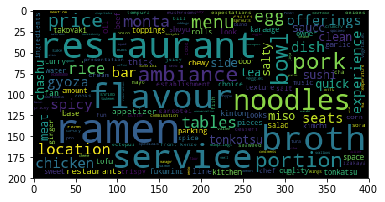

In [14]:
create_wordcloud(open_ramen_df["n"], open_ramen_df["term"])


<a id='open_ramen_states'></a>
### 4.2 Open Ramen Restaurants by State

In [15]:
df_filtered["state"].unique()

array(['OH', 'ON', 'QC', 'PA', 'AZ', 'NV', 'EDH', 'NC'], dtype=object)

In [16]:
def to_df_by_state(df_filtered):
    dict_n = defaultdict(int) 
    dict_scores = defaultdict(int) 
    lst_states = list(df_filtered["state"].unique())
    
    final_df = pd.DataFrame({'term': ['term'], 'score': [1], 'n': [1], 'avg_score': [1], 'state': ['state']})
    
    for state in lst_states:
        dict_n, dict_scores = to_dict(list(df_filtered.loc[df_filtered['state'] == state]["Sentiments"]))
        new_df = to_df(dict_n, dict_scores)
        new_df["state"] = state
        final_df = final_df.append(new_df)
        
    return final_df
        
open_ramen_states_df = to_df_by_state(df_filtered)      
open_ramen_states_df   


,avg_score,n,score,state,term
0,1.000000,1,1.000000,state,term
0,0.430534,28,12.054955,OH,restaurant
1,1.000000,5,5.000000,OH,offerings
2,1.000000,2,2.000000,OH,shrimp
3,0.333333,9,3.000000,OH,price
4,0.694727,23,15.978711,OH,flavour
5,1.000000,1,1.000000,OH,value
6,0.645363,19,12.261905,OH,service
7,0.313548,5,1.567742,OH,sushi
8,1.000000,1,1.000000,OH,ingredients


<a id='closed_ramen_market'></a>
### 4.3 Closed (failed) Ramen Restaurants all Market

In [18]:
## TOKENIZE REVIEWS AND EXRACT THEIR POS

# Without negated words
tokenized_reviews = get_tokens(df_closed, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)

# With negated words
tokenized_reviews_neg = get_tokens(df_closed, stem = False, negation = True, correction = False)
tokenized_pos_neg = get_pos(tokenized_reviews_neg)


In [19]:
NN_count = get_NN_count(tokenized_pos)

review_sentiment_scores = compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True)
review_sentiment_scores[:6]

df_closed["Sentiments"] = list(review_sentiment_scores)
df_closed["NN_count"] = list(NN_count)
df_closed[:3]

,business_id,user_id,category,date,review,stars,useful,funny,cool,name,city,state,latitude,longitude,business_stars,review_count,is_open,Sentiments,NN_count
0,YFEwCxc-9WRRVGgRv_-p7Q,eWD-kLqwCf1MaZxvO4yDLA,Ramen,2015-05-19,Treat this place like your regular Korean rest...,4,1,0,0,Mcramyun,Toronto,ON,43.6562,-79.3923,3.0,25,0,"{'restaurant': 1.0, 'portion': 1.0, 'flavour':...",44
1,YFEwCxc-9WRRVGgRv_-p7Q,KUcRBnqEC8d5rsrGQkrNNg,Ramen,2015-08-03,Ate here blindly without reading any prior rev...,1,1,0,1,Mcramyun,Toronto,ON,43.6562,-79.3923,3.0,25,0,"{'ramen': 1.0, 'seats': -1.0, 'noodles': 1.0, ...",50
2,YFEwCxc-9WRRVGgRv_-p7Q,z8_MT7P1Ri3XYJa1Gmv08g,Ramen,2015-04-29,Unfortunately this was a let down for me.\n\nI...,2,1,0,0,Mcramyun,Toronto,ON,43.6562,-79.3923,3.0,25,0,"{'noodles': -1.0, 'pork': -1.0, 'dumplings': 1...",15


In [20]:
# AGGREGATE TERMS WITH THEIR SENTIMENT
    
dict_n, dict_scores = to_dict(list(df_closed["Sentiments"]))                                     
closed_ramen_df = to_df(dict_n, dict_scores)
closed_ramen_df = closed_ramen_df.sort(['n'], ascending=[0])

closed_ramen_df.to_csv('closed_ramen_df.csv')

closed_ramen_df

c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,term,score,n,avg_score
2,flavour,201.472940,421,0.478558
0,restaurant,135.295335,385,0.351416
4,service,221.640418,382,0.580211
5,ramen,176.273945,337,0.523068
15,broth,97.026916,234,0.414645
55,ambiance,71.931508,174,0.413399
7,noodles,51.336126,140,0.366687
12,menu,44.846086,121,0.370629
3,dish,30.325893,114,0.266017
10,price,36.123232,102,0.354149


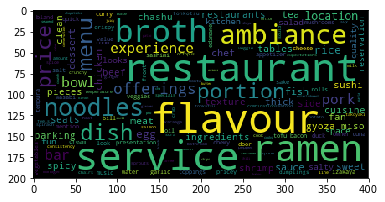

In [21]:
create_wordcloud(closed_ramen_df["n"], closed_ramen_df["term"])


<a id='closed_ramen_states'></a>
### 4.4 Closed (failed) Ramen Restaurants by State

In [22]:

closed_ramen_states_df = to_df_by_state(df_closed)    
closed_ramen_states_df.to_csv('by_state_terms_df_closed.csv')
closed_ramen_states_df


,avg_score,n,score,state,term
0,1.000000,1,1.000000,state,term
0,0.401363,61,24.483127,ON,restaurant
1,0.040000,25,1.000000,ON,portion
2,0.470827,51,24.012199,ON,flavour
3,0.470513,13,6.116667,ON,dish
4,0.818054,53,43.356877,ON,service
5,0.485923,55,26.725757,ON,ramen
6,-0.327820,10,-3.278195,ON,seats
7,0.279082,28,7.814286,ON,noodles
8,0.000000,4,0.000000,ON,curry


<a id='top_ramen_market'></a>
### 4.5 Top Open Ramen Restaurants

In [24]:
## Get reviews that have at least one marked term

tokenized_reviews = get_tokens(df_top, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)

tokenized_reviews_neg = get_tokens(df_top, stem = False, negation = True, correction = False)
tokenized_pos_neg = get_pos(tokenized_reviews_neg)

NN_count = get_NN_count(tokenized_pos)

review_sentiment_scores = compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True)
display(review_sentiment_scores[:3])


df_top["Sentiments"] = list(review_sentiment_scores)
df_top["NN_count"] = list(NN_count)
display(df_top[:3])


# AGGREGATE
dict_n, dict_scores = to_dict(list(df_top["Sentiments"]))                                           
top_ramen_market_df = to_df(dict_n, dict_scores)
top_ramen_market_df = top_ramen_market_df.sort(['n'], ascending=[0])
top_ramen_market_df.to_csv('top_ramen_market_df.csv')
display(top_ramen_market_df[:3])


Tokenization progress:  97.94319294809011 %
POS progress:  97.94319294809011 %
Tokenization progress:  97.94319294809011 %
POS progress:  97.94319294809011 %


[defaultdict(int, {'menu': -1.0, 'service': 1.0, 'specials': 1.0}),
 defaultdict(int,
             {'broth': 1.0,
              'restaurant': -1.0,
              'service': 1.0,
              'sushi': -1.0,
              'teriyaki': 1.0}),
 defaultdict(int, {'broth': 1.0, 'quick': 1.0, 'tea': 1.0})]

,business_id,user_id,category,date,review,stars,useful,funny,cool,name,city,state,latitude,longitude,business_stars,review_count,is_open,Sentiments,NN_count
328,AlxCPmH_gC3uk3hHRBBd1w,ZXSNzKI638WQ3x5iKgM-ug,Ramen,2017-07-03,"Vast menu with over 50 sushi rolls, also noodl...",4,1,0,0,Sushi Plus,Glendale,AZ,33.6116,-112.184,4.5,70,1,"{'menu': -1.0, 'specials': 1.0, 'service': 1.0}",11
329,AlxCPmH_gC3uk3hHRBBd1w,sRcV5rWNfJ9wbB2guzEd7w,Ramen,2017-05-23,I rarely crave sushi but today was the day I a...,4,2,1,1,Sushi Plus,Glendale,AZ,33.6116,-112.184,4.5,70,1,"{'sushi': -1.0, 'teriyaki': 1.0, 'broth': 1.0,...",47
330,AlxCPmH_gC3uk3hHRBBd1w,0eTogTkfrno0lZ4aLWIinw,Ramen,2017-04-21,Made a quick decision to stop by and try this ...,5,1,0,0,Sushi Plus,Glendale,AZ,33.6116,-112.184,4.5,70,1,"{'quick': 1.0, 'tea': 1.0, 'broth': 1.0}",22


c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,term,score,n,avg_score
2,service,299.354193,415,0.721335
6,restaurant,137.448742,381,0.360758
13,flavour,248.156053,377,0.658239


In [45]:
top_ramen_market_df_highcore = top_ramen_market_df.loc[top_ramen_market_df["avg_score"] >0.5]
top_ramen_market_df_highcore = top_ramen_market_df_highcore.loc[top_ramen_market_df_highcore["n"] > 50]
display(top_ramen_market_df_highcore.sort_values(['avg_score'], ascending=[0]))

top_ramen_market_df_lowscore = top_ramen_market_df.loc[top_ramen_market_df["avg_score"] < 0.3]
top_ramen_market_df_lowscore = top_ramen_market_df_lowscore.loc[top_ramen_market_df_lowscore["n"] > 50]
display(top_ramen_market_df_lowscore.sort_values(['avg_score'], ascending=[0]))


,term,n,avg_score
2,service,415,0.721335
3,sushi,69,0.716875
17,offerings,61,0.708102
13,flavour,377,0.658239
15,pork,78,0.614835
22,ramen,354,0.597240
31,price,104,0.585723
44,noodles,151,0.542197
62,chicken,69,0.537161
30,experience,66,0.525084


,term,n,avg_score
28,portion,87,0.207418
108,egg,54,0.199962


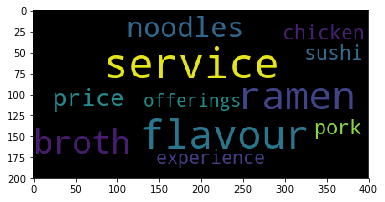

In [26]:
create_wordcloud(top_ramen_market_df_highcore["n"], top_ramen_market_df_highcore["term"])


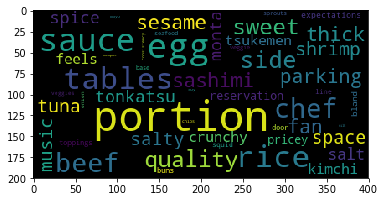

In [27]:
create_wordcloud(top_ramen_market_df_lowscore["n"], top_ramen_market_df_lowscore["term"])


<a id='top_states'></a>
### 4.6 Top Open Ramen Restaurants by State

In [28]:

# BY STATE
top_ramen_states_df = to_df_by_state(df_top)    
top_ramen_states_df.to_csv('top_ramen_states_df.csv')
display(top_ramen_states_df)  


,avg_score,n,score,state,term
0,1.000000,1,1.000000,state,term
0,-1.000000,5,-5.000000,AZ,menu
1,1.000000,2,2.000000,AZ,specials
2,0.753086,27,20.333333,AZ,service
3,0.629552,28,17.627451,AZ,sushi
4,1.000000,4,4.000000,AZ,teriyaki
5,0.706667,10,7.066667,AZ,broth
6,0.128146,21,2.691057,AZ,restaurant
7,1.000000,1,1.000000,AZ,quick
8,1.000000,1,1.000000,AZ,tea


<a id='low'></a>
### 4.7 Worst Open Ramen Restaurants

In [29]:

tokenized_reviews = get_tokens(df_low, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)

tokenized_reviews_neg = get_tokens(df_low, stem = False, negation = True, correction = False)
tokenized_pos_neg = get_pos(tokenized_reviews_neg)

NN_count = get_NN_count(tokenized_pos)

review_sentiment_scores = compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True)
display(review_sentiment_scores[:3])


df_low["Sentiments"] = list(review_sentiment_scores)
df_low["NN_count"] = list(NN_count)
display(df_low[:3])


# AGGREGATE
dict_n, dict_scores = to_dict(list(df_low["Sentiments"]))                                           
low_ramen_market_df = to_df(dict_n, dict_scores)
low_ramen_market_df = low_ramen_market_df.sort(['n'], ascending=[0])
display(low_ramen_market_df[:3])



[defaultdict(int,
             {'dish': 1.0,
              'flavour': 1.0,
              'portion': 1.0,
              'restaurant': 1.0,
              'service': 1.0}),
 defaultdict(int,
             {'curry': -1.0,
              'noodles': 1.0,
              'pork': -0.5000000000000001,
              'price': 1.0,
              'ramen': 1.0,
              'seats': -1.0}),
 defaultdict(int,
             {'dumplings': 1.0,
              'noodles': -1.0,
              'pork': -1.0,
              'service': 1.0})]

,business_id,user_id,category,date,review,stars,useful,funny,cool,name,city,state,latitude,longitude,business_stars,review_count,is_open,Sentiments,NN_count
0,YFEwCxc-9WRRVGgRv_-p7Q,eWD-kLqwCf1MaZxvO4yDLA,Ramen,2015-05-19,Treat this place like your regular Korean rest...,4,1,0,0,Mcramyun,Toronto,ON,43.6562,-79.3923,3.0,25,0,"{'restaurant': 1.0, 'portion': 1.0, 'flavour':...",44
1,YFEwCxc-9WRRVGgRv_-p7Q,KUcRBnqEC8d5rsrGQkrNNg,Ramen,2015-08-03,Ate here blindly without reading any prior rev...,1,1,0,1,Mcramyun,Toronto,ON,43.6562,-79.3923,3.0,25,0,"{'ramen': 1.0, 'seats': -1.0, 'noodles': 1.0, ...",50
2,YFEwCxc-9WRRVGgRv_-p7Q,z8_MT7P1Ri3XYJa1Gmv08g,Ramen,2015-04-29,Unfortunately this was a let down for me.\n\nI...,2,1,0,0,Mcramyun,Toronto,ON,43.6562,-79.3923,3.0,25,0,"{'noodles': -1.0, 'pork': -1.0, 'dumplings': 1...",15


c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,term,score,n,avg_score
2,flavour,132.966548,322,0.412940
5,ramen,131.717360,305,0.431860
0,restaurant,92.487828,299,0.309324


In [30]:
low_ramen_market_df_highcore = low_ramen_market_df.loc[low_ramen_market_df["avg_score"] >0.5]
display(low_ramen_market_df_highcore.loc[low_ramen_market_df_highcore["n"] > 30])

low_ramen_market_df_lowscore = low_ramen_market_df.loc[low_ramen_market_df["avg_score"] < 0.3]
display(low_ramen_market_df_lowscore.loc[low_ramen_market_df_lowscore["n"] > 30])



,term,score,n,avg_score
9,pork,50.214141,99,0.507214
22,offerings,21.624138,37,0.584436


,term,score,n,avg_score
1,portion,14.857143,102,0.145658
10,price,14.768765,99,0.149179
21,bar,11.459058,86,0.133245
12,menu,21.830303,81,0.269510
26,bowl,10.014277,72,0.139087
28,chicken,6.035840,60,0.100597
24,egg,9.044287,58,0.155936
35,rice,14.618615,53,0.275823
58,spicy,8.212121,38,0.216108
33,meat,7.723810,35,0.220680


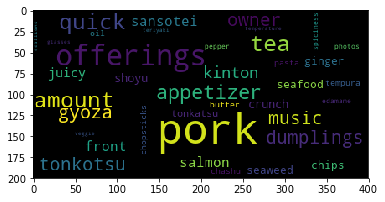

In [31]:
create_wordcloud(low_ramen_market_df_highcore["n"], low_ramen_market_df_highcore["term"])


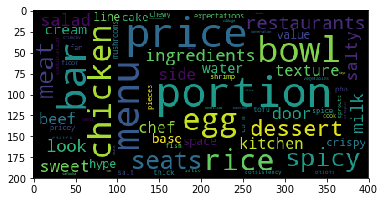

In [32]:
create_wordcloud(low_ramen_market_df_lowscore["n"], low_ramen_market_df_lowscore["term"])


<a id='low_states'></a>
### 4.8 Worst Open Ramen Restaurants by State

In [33]:

# BY STATE
low_ramen_states_df = to_df_by_state(df_low)    
low_ramen_states_df.to_csv('low_ramen_states_df.csv')
display(low_ramen_states_df)


,avg_score,n,score,state,term
0,1.000000,1,1.000000,state,term
0,0.401500,182,73.072939,ON,restaurant
1,0.125808,81,10.190476,ON,portion
2,0.392213,170,66.676245,ON,flavour
3,0.572318,58,33.194433,ON,dish
4,0.274583,186,51.072420,ON,service
5,0.455673,214,97.513920,ON,ramen
6,-0.154407,25,-3.860173,ON,seats
7,0.375223,139,52.155956,ON,noodles
8,0.200000,5,1.000000,ON,curry


<a id='top_vs_low'></a>
### 4.9 Top vs Worst Open Ramen Restaurants Analysis

In [46]:
top_ramen_market_df = top_ramen_market_df[["term", "n", "avg_score"]]
low_ramen_market_df = low_ramen_market_df[["term", "n", "avg_score"]]

df_top_low = pd.merge(top_ramen_market_df, low_ramen_market_df ,on="term")
df_top_low.columns = ['term', 'n_top','avg_score_top', 'n_low', 'avg_score_low']
df_top_low["diff"] = df_top_low["avg_score_low"] - df_top_low["avg_score_top"]

df_top_low.to_csv('df_top_low.csv')

df_top_low_filtered = df_top_low.loc[(df_top_low["n_top"]>50) | (df_top_low["n_low"]>50)]
df_top_low_filtered = df_top_low_filtered.sort_values(['diff'], ascending=[1])


df_top_low_filtered


,term,n_top,avg_score_top,n_low,avg_score_low,diff
13,chicken,69,0.537161,60,0.100597,-0.436563
8,price,104,0.585723,99,0.149179,-0.436543
0,service,415,0.721335,297,0.384873,-0.336462
16,bowl,66,0.442400,72,0.139087,-0.303312
2,flavour,377,0.658239,322,0.412940,-0.245299
14,sushi,69,0.716875,11,0.476874,-0.240001
5,noodles,151,0.542197,194,0.334408,-0.207789
17,bar,63,0.340259,86,0.133245,-0.207014
12,location,73,0.488617,72,0.319823,-0.168794
4,broth,226,0.523956,192,0.357433,-0.166523


<a id='nlp_sentiment_terms2'></a>
## 5 Sentiment for Main Terms in Las Vegas (all relevant Cuisines)
<a id='mysql2'></a>
### 5.1. Load Data : MySQL Queries</a>

In [36]:
connection = MySQLdb.connect("localhost",'root', 'irecasens_2017', 'yelp_db')
cursor = connection.cursor()

sql = "select * from tbl_V_reviews_Vegas" # Extracts Restaurants in Las Vegas

cursor.execute(sql)
df = cursor.fetchall()

connection.close()

df = pd.DataFrame(list(df))
df.columns = ['business_id','review', 'stars', 'useful', 'funny','cool', 'name', 'city', 'neighbourhood', 'state', 'latitude', 'longitude', 'business_stars', 'review_count', 'is_open']
display("Total Reviews: "+ str(len(df)))

df = df.loc[df["useful"] >=1]

df_vegas_top = df.loc[df["business_stars"] >4]
df_vegas_low = df.loc[df["business_stars"] <=3]


df_vegas_closed = df.loc[df["is_open"] == 0]
df_vegas = df.loc[df["is_open"] == 1]

display("Total Reviews (useful): "+ str(len(df)))
display("Top restaurants reviews: "+ str(len(df_vegas_top)))
display("Low restaurants reviews: "+ str(len(df_vegas_low)))
display("Open restaurants reviews: "+ str(len(df_vegas)))
display("Closed restaurants reviews: "+ str(len(df_vegas_closed)))

display(df_vegas.head())


'Total Reviews: 88519'

'Total Reviews (useful): 34580'

'Top restaurants reviews: 9249'

'Low restaurants reviews: 2593'

'Open restaurants reviews: 29031'

'Closed restaurants reviews: 5549'

,business_id,review,stars,useful,funny,cool,name,city,neighbourhood,state,latitude,longitude,business_stars,review_count,is_open
46,-FcZY7a7qgxTUlTvwuyJnQ,This place is located inside of one of my favo...,3,1,0,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
48,-FcZY7a7qgxTUlTvwuyJnQ,hubby and i were losing money at red rock so d...,4,7,5,7,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
54,-FcZY7a7qgxTUlTvwuyJnQ,"Food was okay. Granted they just opened, but s...",2,3,1,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
55,-FcZY7a7qgxTUlTvwuyJnQ,My husband and I came here for lunch and were ...,1,3,1,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
56,-FcZY7a7qgxTUlTvwuyJnQ,First off if you are looking for traditional n...,1,2,0,0,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1


<a id='open_vegas_market'></a>
### 5.2. Open Vegas Restaurants</a>

In [37]:

# Filter reviews that contain at least one marked term.
tokenized_reviews = get_tokens(df_vegas, stem = False, negation = False, correction = False)
to_keep_in = filter_with_marked_terms(tokenized_reviews, df_vegas, marked_terms)

print("Percentage of total reviews that have at least one marked term: " + str(len(to_keep_in) /len(df_vegas)))

df_vegas_filtered = df_vegas[df_vegas.index.isin(to_keep_in)]
df_vegas_filtered


Tokenization progress:  3.444593710171885 %
Tokenization progress:  6.88918742034377 %
Tokenization progress:  10.333781130515655 %
Tokenization progress:  13.77837484068754 %
Tokenization progress:  17.222968550859427 %
Tokenization progress:  20.66756226103131 %
Tokenization progress:  24.112155971203197 %
Tokenization progress:  27.55674968137508 %
Tokenization progress:  31.001343391546964 %
Tokenization progress:  34.445937101718854 %
Tokenization progress:  37.89053081189074 %
Tokenization progress:  41.33512452206262 %
Tokenization progress:  44.77971823223451 %
Tokenization progress:  48.224311942406395 %
Tokenization progress:  51.66890565257828 %
Tokenization progress:  55.11349936275016 %
Tokenization progress:  58.55809307292205 %
Tokenization progress:  62.00268678309393 %
Tokenization progress:  65.44728049326582 %
Tokenization progress:  68.89187420343771 %
Tokenization progress:  72.3364679136096 %
Tokenization progress:  75.78106162378148 %
Tokenization progress:  79.2

,business_id,review,stars,useful,funny,cool,name,city,neighbourhood,state,latitude,longitude,business_stars,review_count,is_open
46,-FcZY7a7qgxTUlTvwuyJnQ,This place is located inside of one of my favo...,3,1,0,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
48,-FcZY7a7qgxTUlTvwuyJnQ,hubby and i were losing money at red rock so d...,4,7,5,7,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
54,-FcZY7a7qgxTUlTvwuyJnQ,"Food was okay. Granted they just opened, but s...",2,3,1,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
55,-FcZY7a7qgxTUlTvwuyJnQ,My husband and I came here for lunch and were ...,1,3,1,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
56,-FcZY7a7qgxTUlTvwuyJnQ,First off if you are looking for traditional n...,1,2,0,0,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
57,-FcZY7a7qgxTUlTvwuyJnQ,This is my usual lunch spot for Noodles at Red...,5,2,2,2,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
59,-FcZY7a7qgxTUlTvwuyJnQ,Not a place I recommend for ramen unless you D...,2,1,0,0,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
61,-FcZY7a7qgxTUlTvwuyJnQ,Would love to give negative stars! My wife and...,1,2,2,0,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
63,-FcZY7a7qgxTUlTvwuyJnQ,Worst noodle house experience ever. Paid $ 12...,1,1,2,0,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1
64,-FcZY7a7qgxTUlTvwuyJnQ,Seeing out dishes come out my first reaction i...,2,2,1,0,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1


In [38]:
## TOKENIZE REVIEWS AND EXRACT THEIR POS

# Without negated words
tokenized_reviews = get_tokens(df_vegas_filtered, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)

# With negated words
tokenized_reviews_neg = get_tokens(df_vegas_filtered, stem = False, negation = True, correction = False)
tokenized_pos_neg = get_pos(tokenized_reviews_neg)

NN_count = get_NN_count(tokenized_pos)

review_sentiment_scores = compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True)

df_vegas_filtered["Sentiments"] = list(review_sentiment_scores)
df_vegas_filtered["NN_count"] = list(NN_count)

# AGGREGATE TERMS WITH THEIR SENTIMENT
    
dict_n, dict_scores = to_dict(list(df_vegas_filtered["Sentiments"]))                                     
df_open_vegas = to_df(dict_n, dict_scores)
df_open_vegas = df_open_vegas.sort_values(['n'], ascending=[0])

df_open_vegas.to_csv('df_open_vegas.csv')

df_open_vegas

Tokenization progress:  9.584970765839165 %
Tokenization progress:  19.16994153167833 %
Tokenization progress:  28.754912297517492 %
Tokenization progress:  38.33988306335666 %
Tokenization progress:  47.924853829195825 %
Tokenization progress:  57.509824595034985 %
Tokenization progress:  67.09479536087414 %
Tokenization progress:  76.67976612671332 %
Tokenization progress:  86.26473689255248 %
Tokenization progress:  95.84970765839165 %
POS progress:  9.584970765839165 %
POS progress:  19.16994153167833 %
POS progress:  28.754912297517492 %
POS progress:  38.33988306335666 %
POS progress:  47.924853829195825 %
POS progress:  57.509824595034985 %
POS progress:  67.09479536087414 %
POS progress:  76.67976612671332 %
POS progress:  86.26473689255248 %
POS progress:  95.84970765839165 %
Tokenization progress:  9.584970765839165 %
Tokenization progress:  19.16994153167833 %
Tokenization progress:  28.754912297517492 %
Tokenization progress:  38.33988306335666 %
Tokenization progress:  47.

c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,term,score,n,avg_score
0,restaurant,1609.391359,4089,0.393590
15,flavour,2323.580749,4087,0.568530
5,service,2033.821902,3670,0.554175
146,sushi,964.542647,1687,0.571750
3,price,588.151764,1246,0.472032
28,ambiance,410.495041,1087,0.377640
26,broth,540.363563,1057,0.511224
14,menu,374.795230,898,0.417367
87,fish,468.532777,808,0.579867
2,portion,250.635392,782,0.320506


In [39]:
def to_df_by_neighbourhood(df_filtered):
    dict_n = defaultdict(int) 
    dict_scores = defaultdict(int) 
    lst_neighbourhood = list(df_filtered["neighbourhood"].unique())
    
    final_df = pd.DataFrame({'term': ['term'], 'score': [1], 'n': [1], 'avg_score': [1], 'neighbourhood': ['neighbourhood']})
    
    for neighbourhood in lst_neighbourhood:
        dict_n, dict_scores = to_dict(list(df_filtered.loc[df_filtered['neighbourhood'] == neighbourhood]["Sentiments"]))
        new_df = to_df(dict_n, dict_scores)
        new_df["neighbourhood"] = neighbourhood
        final_df = final_df.append(new_df)
        
    return final_df
        
vegas_neighbourhood_df = to_df_by_neighbourhood(df_vegas_filtered)      
vegas_neighbourhood_df 

,avg_score,n,neighbourhood,score,term
0,1.000000,1,neighbourhood,1.000000,term
0,0.204173,23,South Summerlin,4.695971,restaurant
1,0.000000,2,South Summerlin,0.000000,meat
2,1.000000,6,South Summerlin,6.000000,portion
3,0.369231,13,South Summerlin,4.800000,price
4,0.111948,24,South Summerlin,2.686741,noodles
5,0.448889,42,South Summerlin,18.853333,service
6,-0.333333,3,South Summerlin,-1.000000,offerings
7,1.000000,4,South Summerlin,4.000000,duck
8,0.500000,4,South Summerlin,2.000000,sauce


In [40]:
neighbourhoods = df_vegas_filtered[["neighbourhood", "latitude", "longitude"]].drop_duplicates().reset_index()
neighbourhoods = neighbourhoods.groupby(["neighbourhood"],as_index = False)[["latitude", "longitude"]].agg('min')
vegas_neighbourhood_df_map = pd.merge(vegas_neighbourhood_df, neighbourhoods ,on="neighbourhood")
vegas_neighbourhood_df_map
    

,avg_score,n,neighbourhood,score,term,latitude,longitude
0,0.204173,23,South Summerlin,4.695971,restaurant,36.1551,-115.335
1,0.000000,2,South Summerlin,0.000000,meat,36.1551,-115.335
2,1.000000,6,South Summerlin,6.000000,portion,36.1551,-115.335
3,0.369231,13,South Summerlin,4.800000,price,36.1551,-115.335
4,0.111948,24,South Summerlin,2.686741,noodles,36.1551,-115.335
5,0.448889,42,South Summerlin,18.853333,service,36.1551,-115.335
6,-0.333333,3,South Summerlin,-1.000000,offerings,36.1551,-115.335
7,1.000000,4,South Summerlin,4.000000,duck,36.1551,-115.335
8,0.500000,4,South Summerlin,2.000000,sauce,36.1551,-115.335
9,1.000000,1,South Summerlin,1.000000,crispy,36.1551,-115.335


<a id='top_vegas_market'></a>
### 5.3. Top Vegas Restaurants</a>

In [41]:

tokenized_reviews = get_tokens(df_vegas_top, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)

tokenized_reviews_neg = get_tokens(df_vegas_top, stem = False, negation = True, correction = False)
tokenized_pos_neg = get_pos(tokenized_reviews_neg)

NN_count = get_NN_count(tokenized_pos)

review_sentiment_scores = compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True)
display(review_sentiment_scores[:3])


df_vegas_top["Sentiments"] = list(review_sentiment_scores)
df_vegas_top["NN_count"] = list(NN_count)
display(df_vegas_top[:3])


# AGGREGATE
dict_n, dict_scores = to_dict(list(df_vegas_top["Sentiments"]))                                           
df_vegas_top = to_df(dict_n, dict_scores)
df_vegas_top = df_vegas_top.sort(['n'], ascending=[0])
df_vegas_top.to_csv('df_vegas_top.csv')
display(df_vegas_top[:3])



Tokenization progress:  10.811979673478215 %
Tokenization progress:  21.62395934695643 %
Tokenization progress:  32.43593902043464 %
Tokenization progress:  43.24791869391286 %
Tokenization progress:  54.05989836739107 %
Tokenization progress:  64.87187804086928 %
Tokenization progress:  75.6838577143475 %
Tokenization progress:  86.49583738782572 %
Tokenization progress:  97.30781706130392 %
POS progress:  10.811979673478215 %
POS progress:  21.62395934695643 %
POS progress:  32.43593902043464 %
POS progress:  43.24791869391286 %
POS progress:  54.05989836739107 %
POS progress:  64.87187804086928 %
POS progress:  75.6838577143475 %
POS progress:  86.49583738782572 %
POS progress:  97.30781706130392 %
Tokenization progress:  10.811979673478215 %
Tokenization progress:  21.62395934695643 %
Tokenization progress:  32.43593902043464 %
Tokenization progress:  43.24791869391286 %
Tokenization progress:  54.05989836739107 %
Tokenization progress:  64.87187804086928 %
Tokenization progress:  

[defaultdict(int, {'cream': 1.0}),
 defaultdict(int,
             {'ingredients': 1.0,
              'restaurant': -0.14285714285714285,
              'seaweed': 1.0}),
 defaultdict(int,
             {'flavour': -1.0,
              'ingredients': 1.0,
              'restaurant': 1.0,
              'sashimi': 1.0,
              'spicy': -1.0,
              'sushi': -1.0})]

c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,business_id,review,stars,useful,funny,cool,name,city,neighbourhood,state,latitude,longitude,business_stars,review_count,is_open,Sentiments,NN_count
1130,-Qkx7W0itbAApcG5lJuMFQ,Walked back here from Linq 30 minutes before s...,5,1,0,1,Jaburritos,Las Vegas,The Strip,NV,36.1176,-115.17,4.5,118,1,{'cream': 1.0},8
1132,-Qkx7W0itbAApcG5lJuMFQ,Definitely a place to try if you're craving su...,4,2,1,1,Jaburritos,Las Vegas,The Strip,NV,36.1176,-115.17,4.5,118,1,"{'restaurant': -0.14285714285714285, 'seaweed'...",16
1145,-Qkx7W0itbAApcG5lJuMFQ,I am so in love with this place! This was one ...,5,3,0,1,Jaburritos,Las Vegas,The Strip,NV,36.1176,-115.17,4.5,118,1,"{'restaurant': 1.0, 'sushi': -1.0, 'spicy': -1...",63


c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,term,score,n,avg_score
1,restaurant,1522.668330,3791,0.401653
6,flavour,2280.531880,3714,0.614037
15,service,2182.507356,3177,0.686971


In [42]:
vegas_top_df_highcore = df_vegas_top.loc[df_vegas_top["avg_score"] >0.5]
vegas_top_df_highcore = vegas_top_df_highcore.loc[vegas_top_df_highcore["n"] > 500]
display(vegas_top_df_highcore.sort_values(['avg_score'], ascending=[0]))

vegas_top_df_lowscore = df_vegas_top.loc[df_vegas_top["avg_score"] < 0.3]
vegas_top_df_lowscore = vegas_top_df_lowscore.loc[vegas_top_df_lowscore["n"] > 200]
display(vegas_top_df_lowscore.sort_values(['avg_score'], ascending=[1]))


,term,score,n,avg_score
15,service,2182.507356,3177,0.686971
9,fish,495.966947,793,0.625431
6,flavour,2280.531880,3714,0.614037
26,offerings,359.893488,602,0.597830
4,sushi,775.468764,1302,0.595598
20,experience,373.681537,682,0.547920
21,price,581.238901,1097,0.529844
66,broth,343.136702,665,0.515995


,term,score,n,avg_score
23,seats,35.998424,236,0.152536
65,fan,37.036043,216,0.171463
61,rice,121.160929,560,0.216359
25,tables,87.606543,393,0.222917
109,side,66.745427,255,0.261747


<a id='low_vegas_market'></a>
### 5.4. Worst Vegas Restaurants</a>

In [43]:

tokenized_reviews = get_tokens(df_vegas_low, stem = False, negation = False, correction = False)
tokenized_pos = get_pos(tokenized_reviews)

tokenized_reviews_neg = get_tokens(df_vegas_low, stem = False, negation = True, correction = False)
tokenized_pos_neg = get_pos(tokenized_reviews_neg)

NN_count = get_NN_count(tokenized_pos)

review_sentiment_scores = compute_sentiment_scores(tokenized_pos, tokenized_pos_neg, max_distance = 5, use_distance = True)
display(review_sentiment_scores[:3])


df_vegas_low["Sentiments"] = list(review_sentiment_scores)
df_vegas_low["NN_count"] = list(NN_count)
display(df_vegas_low[:3])


# AGGREGATE
dict_n, dict_scores = to_dict(list(df_vegas_low["Sentiments"]))                                           
df_vegas_low = to_df(dict_n, dict_scores)
df_vegas_low = df_vegas_low.sort(['n'], ascending=[0])
df_vegas_low.to_csv('df_vegas_low.csv')
display(df_vegas_low[:3])


Tokenization progress:  38.565368299267256 %
Tokenization progress:  77.13073659853451 %
POS progress:  38.565368299267256 %
POS progress:  77.13073659853451 %
Tokenization progress:  38.565368299267256 %
Tokenization progress:  77.13073659853451 %
POS progress:  38.565368299267256 %
POS progress:  77.13073659853451 %


[defaultdict(int,
             {'meat': 1.0,
              'noodles': -1.0,
              'portion': 1.0,
              'price': 1.0,
              'restaurant': 0.07692307692307693,
              'service': -1.0}),
 defaultdict(int,
             {'crispy': 1.0,
              'duck': 1.0,
              'offerings': -1.0,
              'pricey': -1.0,
              'rice': 0.0,
              'sauce': 1.0,
              'scallions': 1.0,
              'service': 1.0,
              'tofu': -1.0}),
 defaultdict(int, {'flavour': -1.0, 'menu': -1.0})]

c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,business_id,review,stars,useful,funny,cool,name,city,neighbourhood,state,latitude,longitude,business_stars,review_count,is_open,Sentiments,NN_count
46,-FcZY7a7qgxTUlTvwuyJnQ,This place is located inside of one of my favo...,3,1,0,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1,"{'restaurant': 0.07692307692307693, 'meat': 1....",25
48,-FcZY7a7qgxTUlTvwuyJnQ,hubby and i were losing money at red rock so d...,4,7,5,7,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1,"{'offerings': -1.0, 'duck': 1.0, 'sauce': 1.0,...",55
54,-FcZY7a7qgxTUlTvwuyJnQ,"Food was okay. Granted they just opened, but s...",2,3,1,1,8 Noodle Bar,Las Vegas,South Summerlin,NV,36.1551,-115.335,3.0,191,1,"{'menu': -1.0, 'flavour': -1.0}",22


c:\users\milo\anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,term,score,n,avg_score
15,flavour,395.457847,1099,0.359834
5,service,260.934026,1062,0.245701
0,restaurant,193.101579,937,0.206085


<a id='low_top_vegas_market'></a>
### 5.4. Top vs. Worst Vegas Restaurants Analysis</a>

In [47]:
df_vegas_top = df_vegas_top[["term", "n", "avg_score"]]
df_vegas_low = df_vegas_low[["term", "n", "avg_score"]]

df_top_low_vegas = pd.merge(df_vegas_top, df_vegas_low ,on="term")
df_top_low_vegas.columns = ['term', 'n_top','avg_score_top', 'n_low', 'avg_score_low']
df_top_low_vegas["diff"] = df_top_low_vegas["avg_score_low"] - df_top_low_vegas["avg_score_top"]
df_top_low_vegas.to_csv('df_top_low_vegas.csv')


df_top_low_vegas_filtered = df_top_low_vegas.loc[(df_top_low_vegas["n_top"]>100) & (df_top_low_vegas["n_low"]>50)]
df_top_low_vegas_filtered = df_top_low_vegas_filtered.sort_values(['diff'], ascending=[1])
df_top_low_vegas_filtered


,term,n_top,avg_score_top,n_low,avg_score_low,diff
11,experience,682,0.547920,185,0.029742,-0.518178
49,shrimp,202,0.464710,59,-0.004983,-0.469693
2,service,3177,0.686971,1062,0.245701,-0.441271
26,meat,365,0.375083,56,-0.032528,-0.407611
30,noodles,335,0.455831,114,0.086266,-0.369565
9,fish,793,0.625431,173,0.261787,-0.363645
16,rice,560,0.216359,216,-0.133833,-0.350192
14,chicken,597,0.475561,129,0.147765,-0.327796
5,price,1097,0.529844,353,0.216503,-0.313341
18,quality,462,0.426205,81,0.165915,-0.260289
